## Deep Learning Applied to Images - Feature Extraction

#### Prof. Thomas da Silva Paula

### Feature extraction example

* Using PyTorch
* Using the convolutional neural network ResNet50

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms

from PIL import Image
from pprint import pprint
from torchvision.models import resnet

plt.rcParams['figure.figsize'] = [15, 5]

## Creating the model

In Pytorch's case, the process is more detailed and there are multiple ways of doing it. In this case, we're overriding the `forward` function so that we can get the features of the last layer before classification.

In [2]:
class Resnet50Features(resnet.ResNet):
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x_feat = torch.flatten(x, 1)

        return x_feat

In [3]:
def resnet50_feature_extractor(pretrained=False, **kwargs):
    model = Resnet50Features(resnet.Bottleneck,
                             [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(resnet.model_urls['resnet50']))
        
    model.eval()
    
    return model

In [4]:
model = resnet50_feature_extractor(pretrained=True)

Pytorch does not have a summary by default like Keras. However, we can isntall `torchsummary`.

`pip install torchsummary`

In [5]:
from torchsummary import summary

In [6]:
summary(model, input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Feature extraction example

In Pytorch, we can use `transforms` to prepare the image to our model.

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
                                transforms.Resize(224),
                                transforms.ToTensor(),
                                normalize
                               ])

The above transforms assume the image must be loaded with PIL.

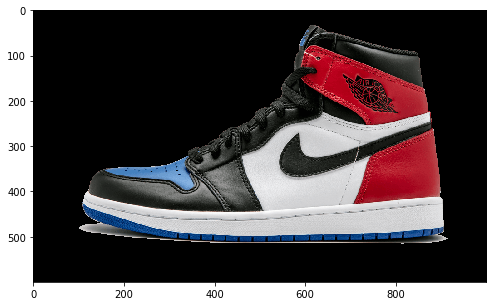

In [8]:
img = Image.open('sample_images/sneakers.png')
img = img.convert(mode='RGB')
plt.imshow(img)

We need to prepare the image using the same preprocessing steps that were used during model training. In this case, we use the transforms.

In [9]:
x = transform(img)
print(x.shape)
x = torch.unsqueeze(x, dim=0)
print(x.shape)

features = model(x)

torch.Size([3, 224, 373])
torch.Size([1, 3, 224, 373])


Verifying the shape and datatype.

In [10]:
print(features.shape, features.dtype)

torch.Size([1, 2048]) torch.float32


Printing the features.

In [11]:
pprint(features.data)

tensor([[0.2258, 0.8851, 0.4853,  ..., 0.1877, 1.8928, 0.3029]])


### Using features for comparison

Image's features can be used for comparison. For example, we can compute the feautres of an image and compare with the features of other images, with the goal of retrieving the most similar ones.

In [12]:
def load_and_extract_features(model, img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    
    # Preprocessing
    img = img.convert(mode='RGB')
    x = transform(img)
    x = torch.unsqueeze(x, dim=0)
    
    # Feature extraction
    features = model(x)
    
    return features.data

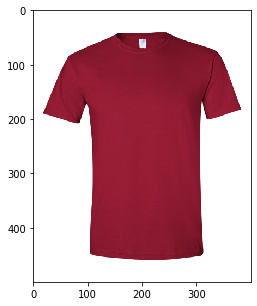

In [13]:
features_tshirt1 = load_and_extract_features(model, 'sample_images/tshirt.png')

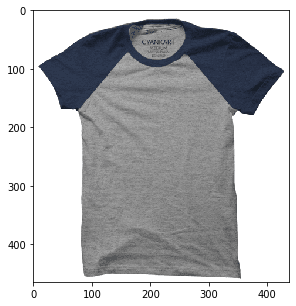

In [14]:
features_tshirt2 = load_and_extract_features(model, 'sample_images/tshirt2.png')

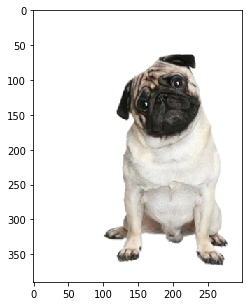

In [15]:
features_pug = load_and_extract_features(model, 'sample_images/pug.png')

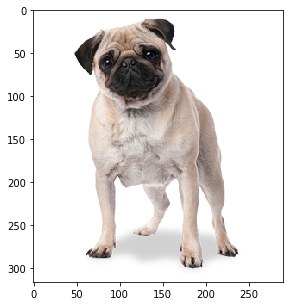

In [16]:
features_pug2 = load_and_extract_features(model, 'sample_images/pug2.png')

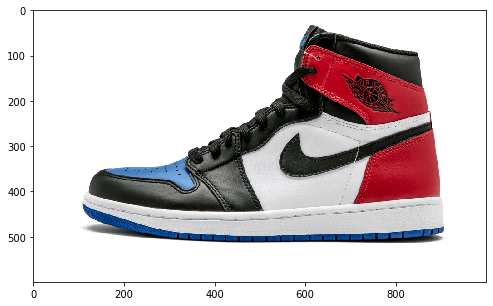

In [17]:
features_sneakers = load_and_extract_features(model, 'sample_images/sneakers.png')

### Computing distance between features
We can then compute the distance between these features and see whether given images are more similar to each other

In [18]:
from scipy.spatial.distance import cosine

#### T-shirt 1 vs Pug 1

In [19]:
distance = cosine(features_tshirt1, features_pug)
print(distance)

0.5245733559131622


#### T-shirt 2 vs Pug 2

In [20]:
distance = cosine(features_tshirt2, features_pug2)
print(distance)

0.49633467197418213


#### Pug 1 vs Sneakers

In [21]:
distance = cosine(features_pug, features_sneakers)
print(distance)

0.41318750381469727


#### T-shirt 1 vs T-shirt 2

In [22]:
distance = cosine(features_tshirt1, features_tshirt2)
print(distance)

0.12110686302185059


#### Pug 1 vs Pug 2

In [23]:
distance = cosine(features_pug, features_pug2)
print(distance)

0.06241333484649658


In [24]:
distance = cosine(features_pug, features_pug)
print(distance)

0.0


### We can also use features for other tasks
We'll see how it works in the assignment :)